# AI PROJECT : EMOTIFY

## FACIAL EMOTION RECOGNITION

### 1. Importing the libraries

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
from livelossplot.inputs.tf_keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.11.0


In [2]:
import pandas as pd
import numpy as np
import cv2

### 2. Checking number of images in each folder

In [3]:
for expression in os.listdir('C:/Users/hp/Documents/dataset/train'):
    print(str(len(os.listdir('C:/Users/hp/Documents/dataset/train/'+ expression))) + " " + expression + " images")

3995 angry images
4097 fear images
7215 happy images
4965 neutral images
4830 sad images
3171 surprise images


In [4]:
for expression in os.listdir('C:/Users/hp/Documents/dataset/test'):
    print(str(len(os.listdir('C:/Users/hp/Documents/dataset/test/'+ expression))) + " " + expression + " images")

958 angry images
1024 fear images
1774 happy images
1233 neutral images
1247 sad images
831 surprise images


### 3. Load the image dataset and preprocess the images

In [5]:
img_size = 50
batch_size = 100
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory('C:/Users/hp/Documents/dataset/train',
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)
datagen_validation = ImageDataGenerator()
validation_generator = datagen_validation.flow_from_directory('C:/Users/hp/Documents/dataset/test',
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 28273 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


### 4. Building the CNN Model

In [6]:
# Initialising the CNN
model = Sequential()
# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(50,50,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
# 2nd Convolution layer
model.add(Conv2D(128,(4,4), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
# 3rd Convolution layer
model.add(Conv2D(256,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
# 4th Convolution layer
model.add(Conv2D(512,(4,4), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
# Flattening
model.add(Flatten())
# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
# Fully connected layer 2nd layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
opt = Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 50, 50, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 50, 50, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 25, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 128)       1

### 5.  Train the model and evaluate the results

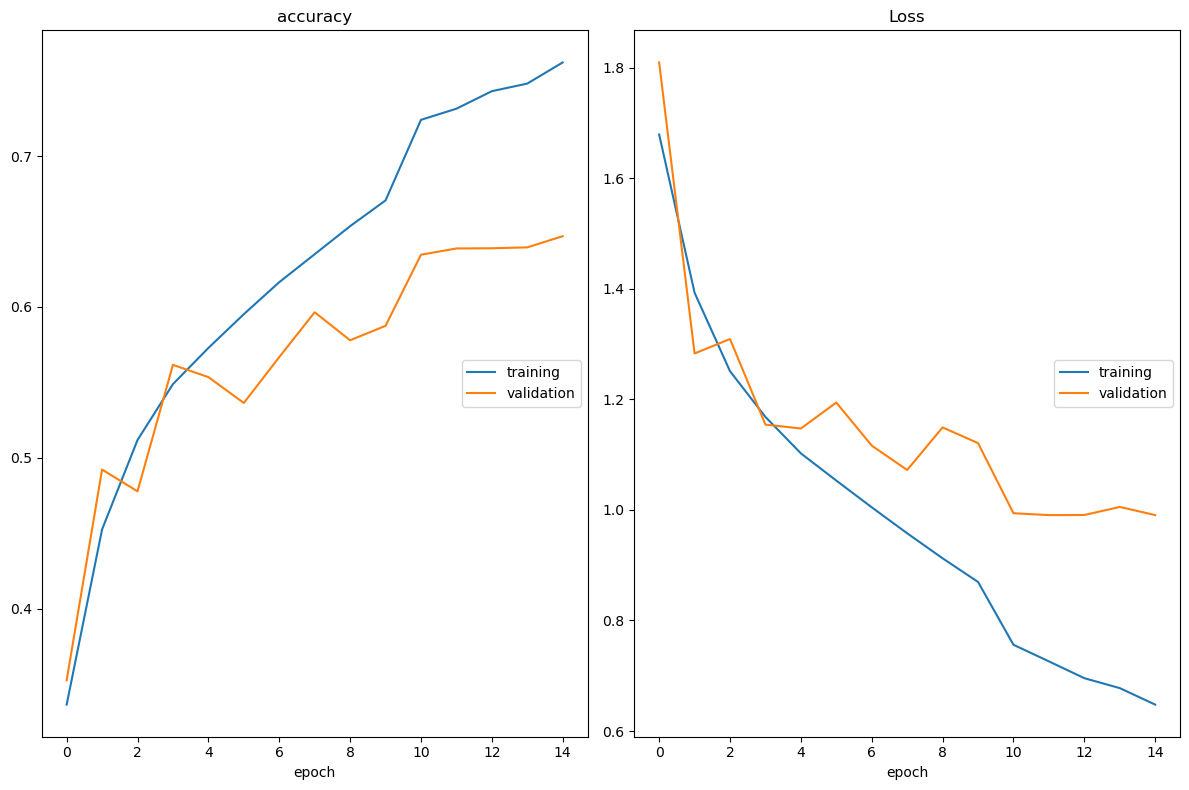

accuracy
	training         	 (min:    0.336, max:    0.762, cur:    0.762)
	validation       	 (min:    0.352, max:    0.647, cur:    0.647)
Loss
	training         	 (min:    0.648, max:    1.679, cur:    0.648)
	validation       	 (min:    0.991, max:    1.810, cur:    0.991)

Epoch 15: saving model to model_weights.h5
282/282 [==============================] - 303s 1s/step - loss: 0.6478 - accuracy: 0.7620 - val_loss: 0.9907 - val_accuracy: 0.6469 - lr: 1.0000e-05
Wall time: 1h 16min 11s


In [7]:
%%time
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesCallback(), checkpoint, reduce_lr]
history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

### 6. Loading the model and weights and making function for predictions

In [8]:
model_json = model.to_json()
model.save_weights('model_weights1.h5')
with open("model1.json", "w") as json_file:
    json_file.write(model_json)

In [3]:
from tensorflow.keras.models import model_from_json
class FacialExpressionModel(object):
    EMOTIONS_LIST = ["Angry","Fear","Happy","Neutral",
                    "Sad","Surprise"]
    def __init__(self, model_json_file, model_weights_file):
        # load model from JSON file
        with open(model_json_file, "r") as json_file:
            loaded_model_json = json_file.read()
            self.loaded_model = model_from_json(loaded_model_json)
        # load weights into the new model
        self.loaded_model.load_weights(model_weights_file)
        self.loaded_model.make_predict_function()
    def predict_emotion(self, img):
        self.preds = self.loaded_model.predict(img)
        return FacialExpressionModel.EMOTIONS_LIST[np.argmax(self.preds)]

### 7. Function for opening webcamera for making prediction and taking screenshot

In [4]:
def open_camera():

    facec = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    model = FacialExpressionModel("model1.json", "model_weights1.h5")
    font = cv2.FONT_HERSHEY_SIMPLEX

    cam = cv2.VideoCapture(0)
    flag=1

    while flag==1:

        ret, fr = cam.read()
        gray_fr = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY)
        faces = facec.detectMultiScale(gray_fr, 1.3, 5)
        for (x, y, w, h) in faces:
            fc = gray_fr[y:y+h, x:x+w]
            roi = cv2.resize(fc, (50,50))
            pred = model.predict_emotion(roi[np.newaxis, :, :, np.newaxis])
            cv2.putText(fr, pred, (x, y), font, 1, (255, 255, 0), 2)
            cv2.rectangle(fr,(x,y),(x+w,y+h),(255,0,0),2)

        if not ret:
            print('failed to grab frame')
            break

        cv2.imshow('Press Spacebar for Screenshot', fr)
        k  = cv2.waitKey(1)

        # if the spacebar key is been pressed
        # screenshots will be taken and screen closed    
        if k%256 == 32:
            img_name = 'ss.png'
            emotion_detected=pred
            cv2.imwrite(img_name, fr)
            print('screenshot taken')
            cam.release()
            cv2.destroyAllWindows()
            print(emotion_detected)
            flag=0
        
    return emotion_detected

## MUSIC EMOTION RECOGNITION

### 1. Importing necessary libraries

In [5]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd

In [6]:
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

In [7]:
from skimage import io
from IPython.display import display

### 2. Making new app using spotify client id and secret

In [8]:
CLIENT_ID = "48e71be9f812455385301425c64dba47"
CLIENT_SECRET = "352c630646304ddfb8fbe33361ee65e0"
sp=spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=CLIENT_ID,client_secret=CLIENT_SECRET))

### 3. Function for extracting music feautures for songs of a playlist

In [9]:
def analyze_playlist(playlist_id):

    playlist_features_list = ["artist","album","track_name","track_id","danceability","energy","key","loudness","mode", "speechiness","acousticness","instrumentalness","liveness","valence","tempo","time_signature"]

    playlist_df = pd.DataFrame(columns = playlist_features_list)

    playlist = sp.playlist(playlist_id)["tracks"]["items"]
    
    for track in playlist:
        playlist_features = {}
        playlist_features["artist"] = track["track"]["album"]["artists"][0]["name"]
        playlist_features["album"] = track["track"]["album"]["name"]
        playlist_features["track_name"] = track["track"]["name"]
        playlist_features["track_id"] = track["track"]["id"]

        audio_features = sp.audio_features(playlist_features["track_id"])[0]
        for feature in playlist_features_list[4:]:
            playlist_features[feature] = audio_features[feature]

        track_df = pd.DataFrame(playlist_features, index = [0])
        playlist_df = pd.concat([playlist_df, track_df], ignore_index = True)

    return playlist_df

### 4. Importing our own music emotion playlists and forming dataset for training

In [10]:
# Array of playlist ids for the corresponding emotion in next array (playlists made by us for the purpose of training)
music_playlists=["1dSlgUfz8xTg6qH5dDJDsC","4bSOcZPrtVEl9kWXGepDBr","7GUe4Fk4c95tN8izMaRNHT","2JS3OdYAEUQXV3ZXHZAOJ5",
                 "164K8qO3M8PiGKQk0taHCs","7Fw0uz2gv0MEI5bjzgIn9A"]
emotion=["Angry","Fear","Happy","Neutral","Sad","Surprise"]

In [11]:
playlist_features_list = ["artist","album","track_name","track_id","danceability","energy","key","loudness","mode", "speechiness","acousticness","instrumentalness","liveness","valence","tempo","time_signature","Emotion"]
df_final = pd.DataFrame(columns = playlist_features_list)
for i in range(len(music_playlists)):
    print(music_playlists[i])
    df=analyze_playlist(music_playlists[i])
    df["Emotion"]=emotion[i]
    df_final=pd.concat([df_final,df])

1dSlgUfz8xTg6qH5dDJDsC
4bSOcZPrtVEl9kWXGepDBr
7GUe4Fk4c95tN8izMaRNHT
2JS3OdYAEUQXV3ZXHZAOJ5
164K8qO3M8PiGKQk0taHCs
7Fw0uz2gv0MEI5bjzgIn9A


In [12]:
df_final.to_csv('music_training.csv')
df_final

,artist,album,track_name,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Emotion
0,Vishal Bhardwaj,Kaminey,Dhan Te Nan,2BOY77LvMTUOfLcnfFAJGl,0.766,0.809,4,-6.206,1,0.1610,0.0227,0.000166,0.0796,0.803,91.987,4,Angry
1,Shashwat Sachdev,Uri - The Surgical Strike (Original Motion Pic...,Challa,2r6UZZ1JdRsDlfIQHKDjST,0.762,0.718,1,-5.039,1,0.1200,0.1050,0.000002,0.1180,0.718,98.019,4,Angry
2,A.R. Rahman,Rockstar,Saadda Haq,7k3jpyYPnVnbO0p7iejWxL,0.554,0.882,6,-5.018,0,0.0488,0.0910,0.000003,0.3680,0.627,96.958,4,Angry
3,Sachet Tandon,"Ghamand Kar (From ""Tanhaji - The Unsung Warrior"")","Ghamand Kar (From ""Tanhaji - The Unsung Warrior"")",4FcZBCb6dANhvsEnFlgJwG,0.465,0.836,6,-4.353,1,0.0632,0.0387,0.00001,0.1300,0.224,169.900,4,Angry
4,Sachin-Jigar,Badlapur (Original Motion Picture Soundtrack),Jee Karda (Rock Version),2xYbk2WDq38a0wuRyjT1mE,0.595,0.815,4,-7.777,0,0.0640,0.3930,0.0,0.2830,0.691,139.993,4,Angry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,Yo Yo Honey Singh,Yo Yo Honey Singh Is Back,"Chaar Botal Vodka (From ""Ragini Mms 2"")",0QHEWicUbdyWuHsMcVd1Ka,0.877,0.881,4,-3.713,0,0.0713,0.4210,0.000345,0.1200,0.874,123.024,4,Surprise
34,Shankar-Ehsaan-Loy,Dil Dhadakne Do,Gallan Goodiyaan,7hNYvX0qAKrxtVr1jGDmvR,0.830,0.858,6,-3.180,0,0.0554,0.1340,0.000017,0.0567,0.949,119.974,4,Surprise
35,Badshah,"Garmi (From ""Street Dancer 3D"")","Garmi (From ""Street Dancer 3D"") (feat. Varun D...",6q9XTgfWilsnyiFofvYrIF,0.788,0.870,9,-5.217,1,0.1770,0.1230,0.000014,0.0692,0.884,109.974,4,Surprise
36,Himesh Reshammiya,Kick,Jumme Ki Raat,2xHMxag2921urhJvdUOmPk,0.688,0.954,1,-3.076,0,0.1450,0.2090,0.00326,0.0387,0.766,140.186,4,Surprise


### 5. Training model on our dataset

In [13]:
X=df_final.iloc[:,4:16]
Y=df_final["Emotion"]

In [23]:
# Train Decision Tree model
model_dt = DecisionTreeClassifier(criterion='entropy',max_depth=7)
model_dt.fit(X,Y)

# Evaluate model on training set
Y_pred_dt = model_dt.predict(X)
print(classification_report(Y,Y_pred_dt))

              precision    recall  f1-score   support

       Angry       0.85      0.93      0.89        30
        Fear       1.00      0.93      0.97        30
       Happy       0.78      0.97      0.86        33
     Neutral       1.00      0.91      0.95        34
         Sad       1.00      0.85      0.92        33
    Surprise       0.97      0.95      0.96        38

    accuracy                           0.92       198
   macro avg       0.93      0.92      0.93       198
weighted avg       0.94      0.92      0.93       198



### 6. Function for recommending songs for a specific emotion from our own playlists

In [16]:
def playlist_recc(emotion_detected):
    emotion=["Angry","Fear","Happy","Neutral","Sad","Surprise"]
    emotion_link=["https://open.spotify.com/playlist/1dSlgUfz8xTg6qH5dDJDsC?si=77feb818f19243db",
                  "https://open.spotify.com/playlist/4bSOcZPrtVEl9kWXGepDBr?si=48e1375826084bb1",
                  "https://open.spotify.com/playlist/7GUe4Fk4c95tN8izMaRNHT?si=68defe8698cf4178",
                  "https://open.spotify.com/playlist/2JS3OdYAEUQXV3ZXHZAOJ5?si=feafe0e7c54d4394",
                  "https://open.spotify.com/playlist/164K8qO3M8PiGKQk0taHCs?si=0e178610461048c6",
                  "https://open.spotify.com/playlist/7Fw0uz2gv0MEI5bjzgIn9A?si=181b150d8e9a4013"]
    for i in range(len(emotion)):
        if emotion_detected == emotion[i]:
            df_subset = df_final.loc[df_final["Emotion"] == emotion[i],['track_name','artist','album']]
            return df_subset.sample(n=10),emotion_link[i]

### 7. Function for returning songs for a specific emotion by predicting on user's playlist

In [17]:
def user_playlist_recc(playlist_id,emotion_detected):
    test_df=analyze_playlist(playlist_id)
    X_test=test_df.iloc[:,4:16]
    test_df["Emotion"]=model_dt.predict(X_test)
    df_subset = test_df.loc[test_df["Emotion"] == emotion_detected,['track_name','artist','album']]
    test_df.to_csv('music emotion predicted.csv')
    print("Songs of emotion ",emotion_detected," from your playlist are : \n")
    return df_subset

## FINAL IMPLEMENTATION

In [27]:
emotion_detected=open_camera()

1/1 [==============================] - 0s 11ms/step
screenshot taken
Happy


In [ ]:
img = io.imread("ss.png")
io.imshow(img)

In [29]:
print("Emotion Detected : ",emotion_detected,"\n")
ch=int(input("Choices for this detected emotion: \n\t1.Recommend songs from our database \n\t2.Predict songs for this emotion from input playlist id \nEnter your choice (1/2) : "))
if ch==1:
    print("\nRecommend songs from our database")
    pl,elink=playlist_recc(emotion_detected)
    print("These are the recommended songs for emotion : ",emotion_predicted)
    display(pl)
    print("For more such reccomendations for emotion",emotion_detected,"visit playlist : ")
    print(elink)
elif ch==2:
    print("\nPredict songs for this emotion from input playlist id")
    playlist_id=input("Enter your playlist id : ")
    user_pl=user_playlist_recc(playlist_id,emotion_detected)
    display(user_pl)

Emotion Detected :  Happy 

Choices for this detected emotion: 
	1.Recommend songs from our database 
	2.Predict songs for this emotion from input playlist id 
Enter your choice (1/2) : 2

Predict songs for this emotion from input playlist id
Enter your playlist id : 6qhzbwUdPmBzfTSnl6bKWw
Songs of emotion  Happy  from your playlist are : 



,track_name,artist,album
1,The Jawaani Song,Vishal-Shekhar,Student of the Year 2 (Original Motion Picture...
4,Kar Gayi Chull,Various Artists,Kapoor & Sons (Since 1921) (Original Motion Pi...
8,Kamariya,Sachin-Jigar,Stree
16,Proper Patola,Mannan Shaah,Namaste England (Original Motion Picture Sound...
18,The Hook Up Song,Vishal-Shekhar,Student of the Year 2 (Original Motion Picture...
20,Kya Baat Ay,Harrdy Sandhu,Kya Baat Ay
27,"Sanedo (From ""Made in China"")",Sachin-Jigar,"Sanedo (From ""Made in China"")"
33,"Ghungroo (From ""War"")",Vishal-Shekhar,"Ghungroo (From ""War"")"
34,"Psycho Saiyaan (From ""Saaho"")",Anirudh Ravichander,"Psycho Saiyaan (From ""Saaho"")"
35,"Bekhayali (From ""Kabir Singh"")",Sachet Tandon,"Bekhayali (From ""Kabir Singh"")"


In [ ]:
# 6qhzbwUdPmBzfTSnl6bKWw top 100 hindi
# 4YOfhHpjPB0tq29NPpDY3F top 100 sad